In [1]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# wrangling
import pandas as pd
import numpy as np

# preparing
#from sklearn.model_selection import train_test_split

# visualizing
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# exploring
import scipy.stats as stats
import pandas_profiling

# modeling
# from sklearn.cluster import KMeans
# from sklearn.preprocessing import LabelEncoder, OneHotEncoder
# from sklearn.linear_model import LinearRegression
# from statsmodels.formula.api import ols
# from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
# from sklearn.feature_selection import f_regression
# from math import sqrt

# 3D projection
from mpl_toolkits.mplot3d import Axes3D

pd.options.display.float_format = '{:20,.2f}'.format

# my modules
import acquire
import summarize
import prepare

# default pandas decimal number display format
pd.options.display.float_format = '{:20,.2f}'.format

In [2]:
df = acquire.get_zillow_data()

- Read in 52,169 rows

In [3]:
df.shape

(52169, 72)

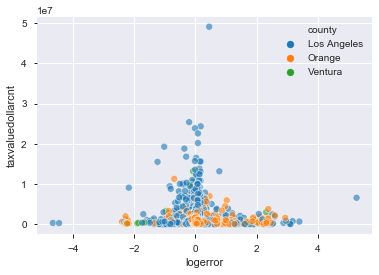

In [4]:
sns.scatterplot(data=df, x="logerror", y="taxvaluedollarcnt", hue="county", hue_order=["Los Angeles", "Orange", "Ventura"] , alpha=.6)

In [5]:
df = prepare.remove_outliers_iqr(df, columns=["bedroomcnt", "bathroomcnt"], k=1.5)
df.shape

(49543, 72)

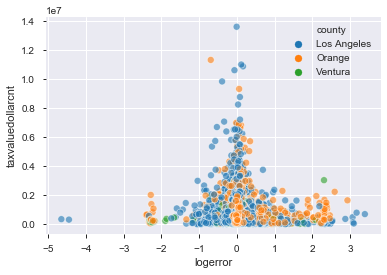

In [6]:
sns.scatterplot(data=df, x="logerror", y="taxvaluedollarcnt", hue="county", hue_order=["Los Angeles", "Orange", "Ventura"], alpha=.6)